In [2]:
!pip install torch_geometric

In [3]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'  # For debugging
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.utils import from_scipy_sparse_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
import scipy.sparse as sp
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import gc
import logging

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logger.info(f"Using device: {device}")

# 1. Data Loading and Preprocessing
def load_and_preprocess_data(file_path='NB15_TRAIN.csv', sample_size=20000):
    logger.info(f"Loading and preprocessing UNSW-NB15 dataset from {file_path}...")
    data_df = pd.read_csv(file_path)
    
    normal_df = data_df[data_df['label'] == 0]
    anomaly_df = data_df[data_df['label'] == 1]
    anomaly_df = anomaly_df.sample(n=len(normal_df), replace=True, random_state=42) 
    data_df = pd.concat([normal_df, anomaly_df]).sample(n=sample_size, random_state=42)

    categorical_cols = ['proto', 'service', 'state', 'attack_cat']
    temporal_cols = ['Stime', 'Ltime'] if 'Stime' in data_df.columns else []
    numerical_cols = list(set(data_df.columns) - set(categorical_cols + temporal_cols + ['label', 'id']))

    label_encoders = {}
    for col in categorical_cols:
        if col in data_df.columns:
            label_encoders[col] = LabelEncoder()
            data_df[col] = label_encoders[col].fit_transform(data_df[col].astype(str))
            numerical_cols.append(col)

    scaler = StandardScaler()
    data_df[numerical_cols] = scaler.fit_transform(data_df[numerical_cols])
    data_df[numerical_cols] = data_df[numerical_cols].fillna(data_df[numerical_cols].mean())

    temporal_features = data_df[temporal_cols].values if temporal_cols else np.zeros((len(data_df), 1))
    node_features_np = data_df[numerical_cols].values
    labels_np = data_df['label'].values

    return node_features_np, labels_np, temporal_features, numerical_cols
    
# 2. Graph Construction
def dynamic_contextual_graph_construction(features, temporal_data, k=20, context_window=7, similarity_threshold=0.6, batch_size=900):
    logger.info(f"Constructing graph using Dynamic Contextual Similarity (k={k}, window={context_window})...")
    num_nodes = features.shape[0]
    adj_matrix = sp.lil_matrix((num_nodes, num_nodes))

    features_tensor = torch.tensor(features, dtype=torch.float, device=device)
    behavioral_features = min(5, features.shape[1])
    behavioral_context = np.zeros((num_nodes, behavioral_features))

    for start in range(0, num_nodes, batch_size):
        end = min(start + batch_size, num_nodes)
        for i in range(start, end):
            start_idx = max(0, i - context_window // 2)
            end_idx = min(num_nodes, i + context_window // 2 + 1)
            context = features[start_idx:end_idx, :behavioral_features]
            behavioral_context[i] = np.mean(context, axis=0)
        gc.collect()

    behavioral_context_tensor = torch.tensor(behavioral_context, dtype=torch.float, device=device)
    for start in range(0, num_nodes, batch_size):
        end = min(start + batch_size, num_nodes)
        batch_indices = slice(start, end)
        
        batch_features = features_tensor[batch_indices]
        feature_sim = 1 - torch.cdist(batch_features, features_tensor, p=2).square() / (batch_features.norm(p=2, dim=1, keepdim=True) * features_tensor.norm(p=2, dim=1)).clamp(min=1e-10)

        if temporal_data.size > 0 and temporal_data.shape[1] > 0:
            temporal_tensor = torch.tensor(temporal_data[:, 0], dtype=torch.float, device=device)
            temporal_weight = torch.exp(-torch.abs(temporal_tensor[start:end].unsqueeze(1) - temporal_tensor.unsqueeze(0)) / 3600)
        else:
            temporal_weight = torch.ones((end - start, num_nodes), device=device)

        batch_context = behavioral_context_tensor[batch_indices]
        context_sim = 1 - torch.cdist(batch_context, behavioral_context_tensor, p=2).square() / (batch_context.norm(p=2, dim=1, keepdim=True) * behavioral_context_tensor.norm(p=2, dim=1)).clamp(min=1e-10)

        dcs_score = 0.4 * feature_sim + 0.3 * temporal_weight + 0.3 * context_sim
        dcs_score = torch.clamp(dcs_score, min=0, max=1)  # Prevent NaNs

        top_k_values, top_k_indices = torch.topk(dcs_score, k + 1, dim=1)
        mask = top_k_values[:, :-1] > similarity_threshold
        for i in range(end - start):
            if mask[i].sum() > 0:
                j_indices = top_k_indices[i, :-1][mask[i]]
                weights = top_k_values[i, :-1][mask[i]]
                for j, w in zip(j_indices.cpu().numpy(), weights.cpu().numpy()):
                    adj_matrix[start + i, j] = w
                    adj_matrix[j, start + i] = w

        logger.info(f"Processed batch {start//batch_size + 1}/{(num_nodes//batch_size) + 1}")
        gc.collect()
        if device.type == 'cuda':
            torch.cuda.empty_cache()

    edge_index, edge_weight = from_scipy_sparse_matrix(adj_matrix)
    edge_weight = (edge_weight - edge_weight.min()) / (edge_weight.max() - edge_weight.min() + 1e-10)
    edge_weight = torch.tensor(edge_weight, dtype=torch.float, device=device) + 1e-6  # Avoid zeros
    return edge_index, edge_weight, adj_matrix

# 3. Enhanced GAE Model 
class EnhancedGAE(torch.nn.Module):
    def __init__(self, input_dim, hidden_dims=[1024, 512, 256, 128, 64], dropout=0.4):
        super(EnhancedGAE, self).__init__()
        self.encoder_layers = torch.nn.ModuleList()
        prev_dim = input_dim
        for dim in hidden_dims:
            self.encoder_layers.append(GCNConv(prev_dim, dim))
            prev_dim = dim
        self.dropout = torch.nn.Dropout(dropout)
        self.layer_norms = torch.nn.ModuleList([nn.LayerNorm(dim) for dim in hidden_dims])

        self.classifier = torch.nn.Sequential(
            nn.Linear(hidden_dims[-1], 32),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(16, 1)
        )

    def encode(self, x, edge_index, edge_weight=None):
        h = x
        for i, conv in enumerate(self.encoder_layers):
            h = conv(h, edge_index, edge_weight)
            h = self.layer_norms[i](h)
            h = F.relu(h) if i < len(self.encoder_layers) - 1 else h
            h = self.dropout(h)
        return h

    def decode(self, z, edge_index):
        edge_logits = (z[edge_index[0]] * z[edge_index[1]]).sum(dim=1)
        return edge_logits

    def forward(self, x, edge_index, edge_weight=None):
        z = self.encode(x, edge_index, edge_weight)
        edge_logits = self.decode(z, edge_index)
        class_logits = self.classifier(z)
        return edge_logits, class_logits, z
        
# 4. Training 
def train_enhanced_gae(model, data, optimizer, epochs=500, patience=100):  
    logger.info("Starting Enhanced GAE training with hybrid loss...")
    model.train()

    adj = data.edge_weight  # Use weighted adjacency
    labels = data.y.float()
    pos_weight = torch.tensor([float((labels == 0).sum()) / ((labels == 1).sum() + 1e-10)]).to(device)
    train_losses = []
    best_loss = float('inf')
    patience_counter = 0

    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    for epoch in range(epochs):
        optimizer.zero_grad()
        edge_logits, class_logits, z = model(data.x, data.edge_index, edge_weight=data.edge_weight)

        recon_loss = F.binary_cross_entropy_with_logits(edge_logits, adj, reduction='mean')
        recon_loss = torch.clamp(recon_loss, max=10.0)  # Clip loss
        class_loss = F.binary_cross_entropy_with_logits(class_logits.squeeze(), labels, pos_weight=pos_weight)
        loss = 0.5 * recon_loss + 0.5 * class_loss + 0.001 * torch.norm(z, p=2)

        if torch.isnan(loss):
            logger.warning("NaN detected in loss, skipping update")
            continue

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
        optimizer.step()
        scheduler.step()

        train_losses.append(loss.item())
        if (epoch + 1) % 25 == 0:
            logger.info(f"Epoch {epoch + 1}/{epochs} | Loss: {loss.item():.4f}")

        if loss.item() < best_loss and not torch.isnan(loss):
            best_loss = loss.item()
            patience_counter = 0
            torch.save(model.state_dict(), 'best_enhanced_gae.pt')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                logger.info(f"Early stopping at epoch {epoch + 1}")
                break

        gc.collect()
        if device.type == 'cuda':
            torch.cuda.empty_cache()

    return train_losses

# 5. Anomaly Detection
def detect_anomalies_with_tbds(model, data, adj_matrix, temporal_features, features, threshold_percentile=54, alpha=0.05, beta=0.25, gamma=0.25, batch_size=1000):
    logger.info("Detecting anomalies with tuned TBDS...")
    model.eval()
    num_nodes = data.x.shape[0]

    recon_errors = np.zeros(num_nodes)
    tbds = np.zeros(num_nodes)
    z_full = np.zeros((num_nodes, 64))
    class_scores = np.zeros(num_nodes)

    with torch.no_grad():
        for start in range(0, num_nodes, batch_size):
            end = min(start + batch_size, num_nodes)
            batch_indices = torch.arange(start, end, device=device)

            mask = (data.edge_index[0] >= start) & (data.edge_index[0] < end)
            batch_edge_index = data.edge_index[:, mask]
            batch_edge_weight = data.edge_weight[mask]

            batch_nodes = torch.unique(batch_edge_index)
            node_mapping = {old_idx.item(): new_idx for new_idx, old_idx in enumerate(batch_nodes)}

            batch_edge_index_mapped = torch.zeros_like(batch_edge_index)
            for i in range(batch_edge_index.shape[1]):
                batch_edge_index_mapped[0, i] = node_mapping[batch_edge_index[0, i].item()]
                batch_edge_index_mapped[1, i] = node_mapping[batch_edge_index[1, i].item()]

            batch_x = data.x[batch_nodes]
            edge_logits, class_logits, z = model(batch_x, batch_edge_index_mapped, batch_edge_weight)

            adj_orig = batch_edge_weight
            edge_probs = torch.sigmoid(edge_logits)
            batch_recon_errors = (edge_probs - adj_orig) ** 2
            batch_recon_errors = torch.nan_to_num(batch_recon_errors, nan=0.0)

            for idx, node in enumerate(batch_nodes):
                neighbor_mask = batch_edge_index[0] == node_mapping[node.item()]
                if neighbor_mask.sum() > 0:
                    recon_errors[node] = batch_recon_errors[neighbor_mask].mean().cpu().numpy()
                else:
                    recon_errors[node] = 0.0  # Default for isolated nodes
                class_scores[node] = torch.sigmoid(class_logits[idx]).item()
                z_full[node] = z[idx].cpu().numpy()

    recon_score = (recon_errors - recon_errors.min()) / (recon_errors.max() - recon_errors.min() + 1e-10)

    temporal_drift = np.zeros(num_nodes)
    if temporal_features.size > 0 and temporal_features.shape[1] > 0:
        temporal_tensor = torch.tensor(temporal_features[:, 0], dtype=torch.float, device=device)
        temporal_diff = torch.abs(temporal_tensor - temporal_tensor.mean()).cpu().numpy()
        temporal_drift = temporal_diff / (temporal_diff.max() + 1e-10)

    behavioral_incon = torch.zeros(num_nodes, device=device)
    x_tensor = data.x
    for start in range(0, num_nodes, batch_size):
        end = min(start + batch_size, num_nodes)
        batch_mask = (data.edge_index[0] >= start) & (data.edge_index[0] < end)
        batch_edges = data.edge_index[:, batch_mask]
        unique_nodes = torch.unique(batch_edges[0])
        for i in unique_nodes:
            neighbors = data.edge_index[1][data.edge_index[0] == i]
            if len(neighbors) > 0:
                mean_neighbor = x_tensor[neighbors].mean(dim=0)
                behavioral_incon[i] = torch.norm(x_tensor[i] - mean_neighbor, p=2)
    behavioral_score = behavioral_incon.cpu().numpy()
    behavioral_score = (behavioral_score - behavioral_score.min()) / (behavioral_score.max() - behavioral_score.min() + 1e-10)

    tbds = alpha * recon_score + beta * temporal_drift + gamma * behavioral_score + 0.5 * class_scores
    tbds = np.nan_to_num(tbds, nan=0.0)
    threshold = np.percentile(tbds, threshold_percentile)
    anomalies = (tbds > threshold)
    
    num_anomalies = anomalies.sum()
    logger.info(f"Detected {num_anomalies} anomalies (Threshold: {threshold:.4f})")

    return anomalies, tbds, recon_errors, z_full
    
# 6. Evaluation Metrics
def evaluate_anomaly_detection(y_true, anomalies, tbds, recon_errors):
    logger.info("Evaluating anomaly detection performance...")
    metrics = {}

    tbds = np.nan_to_num(tbds, nan=0.0)
    recon_errors = np.nan_to_num(recon_errors, nan=0.0)

    metrics['tbds_roc_auc'] = roc_auc_score(y_true, tbds)
    precision, recall, _ = precision_recall_curve(y_true, tbds)
    metrics['tbds_pr_auc'] = auc(recall, precision)
    metrics['tbds_accuracy'] = accuracy_score(y_true, anomalies)
    metrics['tbds_precision'] = precision_score(y_true, anomalies, zero_division=0)
    metrics['tbds_recall'] = recall_score(y_true, anomalies)
    metrics['tbds_f1'] = f1_score(y_true, anomalies)

    metrics['recon_roc_auc'] = roc_auc_score(y_true, recon_errors)
    recon_precision, recon_recall, _ = precision_recall_curve(y_true, recon_errors)
    metrics['recon_pr_auc'] = auc(recon_recall, recon_precision)

    logger.info("\n--- TBDS Metrics ---")
    logger.info(f"ROC-AUC: {metrics['tbds_roc_auc']:.4f}")
    logger.info(f"PR-AUC: {metrics['tbds_pr_auc']:.4f}")
    logger.info(f"Accuracy: {metrics['tbds_accuracy']:.4f}")
    logger.info(f"Precision: {metrics['tbds_precision']:.4f}")
    logger.info(f"Recall: {metrics['tbds_recall']:.4f}")
    logger.info(f"F1-Score: {metrics['tbds_f1']:.4f}")
    logger.info("\n--- Reconstruction Error Metrics ---")
    logger.info(f"ROC-AUC: {metrics['recon_roc_auc']:.4f}")
    logger.info(f"PR-AUC: {metrics['recon_pr_auc']:.4f}")

    return metrics

# 7. Visualization
def visualize_comprehensive_results(train_losses, tbds, recon_errors, y_true, z, G):
    logger.info("Generating visualizations...")
    plt.figure(figsize=(24, 16))

    plt.subplot(2, 3, 1)
    plt.plot(train_losses, color='blue', linewidth=2)
    plt.title("Training Loss Over Epochs", fontsize=14)
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Loss", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.subplot(2, 3, 2)
    num_anomalies = (y_true == 1).sum()
    sns.histplot(tbds[y_true == 0], bins=50, color='green', alpha=0.5, label=f'Normal (n={len(y_true)-num_anomalies})')
    sns.histplot(tbds[y_true == 1], bins=50, color='red', alpha=0.5, label=f'Anomalies (n={num_anomalies})')
    plt.title(f"TBDS Distribution (Total Anomalies: {num_anomalies})", fontsize=14)
    plt.xlabel("TBDS Score", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.legend(fontsize=10)

    plt.subplot(2, 3, 3)
    sns.histplot(recon_errors[y_true == 0], bins=50, color='blue', alpha=0.5, label='Normal')
    sns.histplot(recon_errors[y_true == 1], bins=50, color='orange', alpha=0.5, label='Anomalies')
    plt.title("Reconstruction Errors", fontsize=14)
    plt.xlabel("Error", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.legend(fontsize=10)

    plt.subplot(2, 3, 4)
    plt.scatter(z[y_true == 0, 0], z[y_true == 0, 1], c='green', alpha=0.5, label='Normal', s=10)
    plt.scatter(z[y_true == 1, 0], z[y_true == 1, 1], c='red', alpha=0.5, label='Anomalies', s=10)
    plt.title("Latent Space Projection", fontsize=14)
    plt.xlabel("Z1", fontsize=12)
    plt.ylabel("Z2", fontsize=12)
    plt.legend(fontsize=10)

    plt.subplot(2, 3, 5)
    node_colors = ['red' if y_true[i] == 1 else 'green' for i in range(len(y_true))]
    nx.draw_spring(G, node_size=15, alpha=0.6, node_color=node_colors[:len(G.nodes())], edge_color='grey', width=0.5)
    plt.title(f"Graph Structure (Red=Anomalies, {num_anomalies} detected)", fontsize=14)

    plt.subplot(2, 3, 6)
    plt.scatter(recon_errors[y_true == 0], tbds[y_true == 0], c='green', alpha=0.3, label='Normal')
    plt.scatter(recon_errors[y_true == 1], tbds[y_true == 1], c='red', alpha=0.3, label='Anomalies')
    plt.title("TBDS vs Reconstruction Errors", fontsize=14)
    plt.xlabel("Reconstruction Error", fontsize=12)
    plt.ylabel("TBDS Score", fontsize=12)
    plt.legend(fontsize=10)

    plt.tight_layout()
    plt.savefig('visualizations.png', dpi=300, bbox_inches='tight')
    plt.close()

# 8. Main Execution 
def main():
    try:
        features, labels, temporal_features, feature_cols = load_and_preprocess_data(sample_size=20000)
        edge_index, edge_weight, adj_matrix = dynamic_contextual_graph_construction(
            features, temporal_features, k=20, similarity_threshold=0.6, batch_size=900
        )
        node_features = torch.tensor(features, dtype=torch.float).to(device)
        labels = torch.tensor(labels, dtype=torch.long).to(device)
        edge_index = edge_index.to(device)
        edge_weight = edge_weight.to(device)
        data = Data(x=node_features, edge_index=edge_index, edge_weight=edge_weight, y=labels).to(device)

        model = EnhancedGAE(input_dim=len(feature_cols), hidden_dims=[1024, 512, 256, 128, 64], dropout=0.4).to(device)
        optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-5)
        train_losses = train_enhanced_gae(model, data, optimizer, epochs=500, patience=100)  

        model.load_state_dict(torch.load('best_enhanced_gae.pt'))
        anomalies, tbds, recon_errors, z = detect_anomalies_with_tbds(
            model, data, adj_matrix, temporal_features, features,
            threshold_percentile=54, alpha=0.05, beta=0.25, gamma=0.25, batch_size=1000
        )

        metrics = evaluate_anomaly_detection(labels.cpu().numpy(), anomalies, tbds, recon_errors)

        sample_size = 1000
        G = nx.Graph()
        sample_indices = np.random.choice(len(features), sample_size, replace=False)
        sample_mask = (edge_index[0] < sample_size) & (edge_index[1] < sample_size)
        sample_edges = edge_index[:, sample_mask].cpu().numpy().T
        G.add_edges_from(sample_edges)
        visualize_comprehensive_results(train_losses, tbds, recon_errors, labels.cpu().numpy(), z, G)

        results = {
            'metrics': metrics,
            'tbds': tbds,
            'recon_errors': recon_errors,
            'anomalies': anomalies,
            'train_losses': train_losses,
            'num_anomalies': anomalies.sum() 
        }
        np.savez('anomaly_detection_results.npz', **results)
        logger.info(f"Results saved with {anomalies.sum()} anomalies detected.")

    except Exception as e:
        logger.error(f"An error occurred: {e}")
        raise

if __name__ == "__main__":
    main()

2025-04-14 20:52:15,177 - INFO - Using device: cpu
2025-04-14 20:52:15,189 - INFO - Loading and preprocessing UNSW-NB15 dataset from NB15_TRAIN.csv...
2025-04-14 20:52:17,154 - INFO - Constructing graph using Dynamic Contextual Similarity (k=20, window=7)...
2025-04-14 20:52:21,027 - INFO - Processed batch 1/23
2025-04-14 20:52:21,782 - INFO - Processed batch 2/23
2025-04-14 20:52:22,548 - INFO - Processed batch 3/23
2025-04-14 20:52:23,234 - INFO - Processed batch 4/23
2025-04-14 20:52:23,974 - INFO - Processed batch 5/23
2025-04-14 20:52:24,676 - INFO - Processed batch 6/23
2025-04-14 20:52:25,384 - INFO - Processed batch 7/23
2025-04-14 20:52:26,104 - INFO - Processed batch 8/23
2025-04-14 20:52:26,818 - INFO - Processed batch 9/23
2025-04-14 20:52:27,530 - INFO - Processed batch 10/23
2025-04-14 20:52:28,243 - INFO - Processed batch 11/23
2025-04-14 20:52:28,949 - INFO - Processed batch 12/23
2025-04-14 20:52:29,663 - INFO - Processed batch 13/23
2025-04-14 20:52:30,478 - INFO - Pr

2025-04-14 22:26:57,420 - INFO - Using device: cpu
2025-04-14 22:26:57,461 - INFO - Loading and preprocessing UNSW-NB15 dataset from NB15_TRAIN.csv...
2025-04-14 22:26:58,763 - INFO - Constructing graph using Dynamic Contextual Similarity (k=20, window=5)...
2025-04-14 22:27:09,484 - INFO - Processed batch 1/51
2025-04-14 22:27:10,022 - INFO - Processed batch 2/51
2025-04-14 22:27:10,556 - INFO - Processed batch 3/51
2025-04-14 22:27:11,081 - INFO - Processed batch 4/51
2025-04-14 22:27:11,599 - INFO - Processed batch 5/51
2025-04-14 22:27:12,150 - INFO - Processed batch 6/51
2025-04-14 22:27:12,684 - INFO - Processed batch 7/51
2025-04-14 22:27:13,224 - INFO - Processed batch 8/51
2025-04-14 22:27:13,755 - INFO - Processed batch 9/51
2025-04-14 22:27:14,237 - INFO - Processed batch 10/51
2025-04-14 22:27:14,684 - INFO - Processed batch 11/51
2025-04-14 22:27:15,134 - INFO - Processed batch 12/51
2025-04-14 22:27:15,571 - INFO - Processed batch 13/51
2025-04-14 22:27:16,030 - INFO - Pr

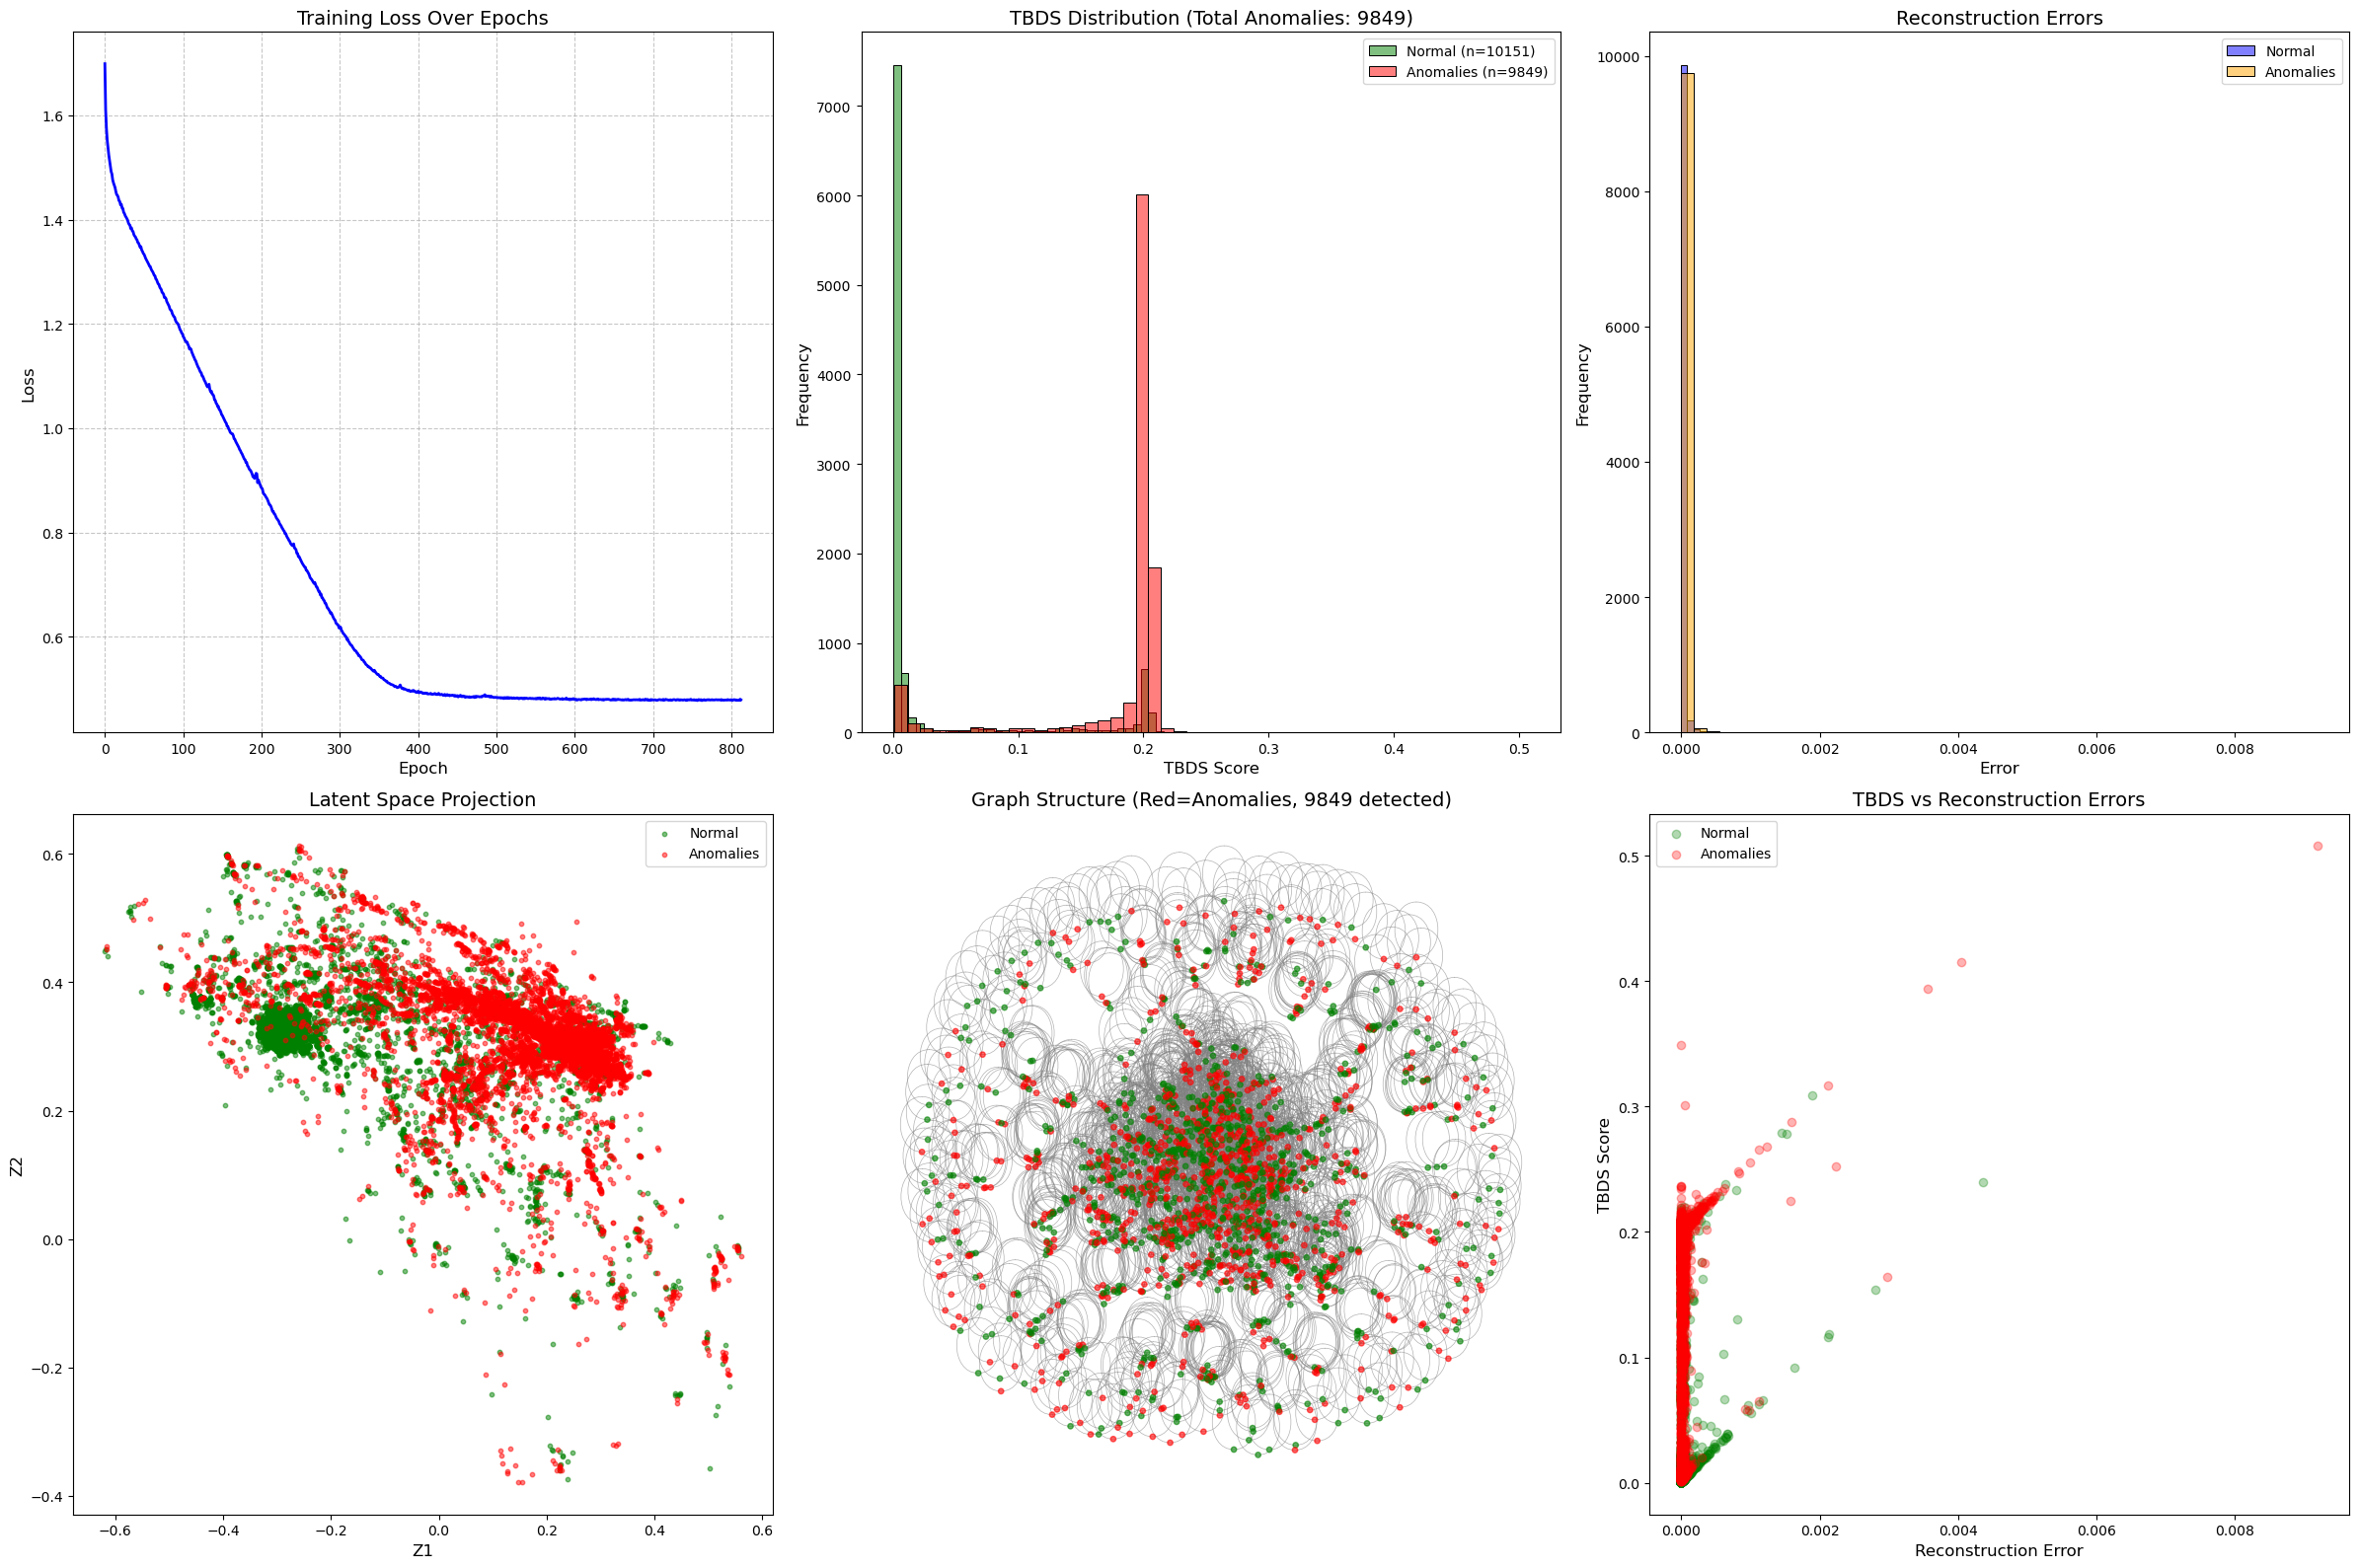

2025-04-15 00:33:35,064 - INFO - Results saved with 10000 anomalies detected.


In [8]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'  # For debugging
import torch
import torch.nn.functional as F
import pandas as pd
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.utils import from_scipy_sparse_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
import scipy.sparse as sp
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import gc
import logging

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logger.info(f"Using device: {device}")

# 1. Data Loading and Preprocessing
def load_and_preprocess_data(file_path='NB15_TRAIN.csv', sample_size=50000):
    logger.info(f"Loading and preprocessing UNSW-NB15 dataset from {file_path}...")
    data_df = pd.read_csv(file_path)
    
    normal_df = data_df[data_df['label'] == 0]
    anomaly_df = data_df[data_df['label'] == 1]
    anomaly_df = anomaly_df.sample(n=len(normal_df), replace=True, random_state=42) 
    data_df = pd.concat([normal_df, anomaly_df]).sample(n=sample_size, random_state=42)

    categorical_cols = ['proto', 'service', 'state', 'attack_cat']
    temporal_cols = ['Stime', 'Ltime'] if 'Stime' in data_df.columns else []
    numerical_cols = list(set(data_df.columns) - set(categorical_cols + temporal_cols + ['label', 'id']))

    label_encoders = {}
    for col in categorical_cols:
        if col in data_df.columns:
            label_encoders[col] = LabelEncoder()
            data_df[col] = label_encoders[col].fit_transform(data_df[col].astype(str))
            numerical_cols.append(col)

    scaler = StandardScaler()
    data_df[numerical_cols] = scaler.fit_transform(data_df[numerical_cols])
    data_df[numerical_cols] = data_df[numerical_cols].fillna(data_df[numerical_cols].mean())

    temporal_features = data_df[temporal_cols].values if temporal_cols else np.zeros((len(data_df), 1))
    node_features_np = data_df[numerical_cols].values
    labels_np = data_df['label'].values

    return node_features_np, labels_np, temporal_features, numerical_cols
    
# 2. Graph Construction
def dynamic_contextual_graph_construction(features, temporal_data, k=5, context_window=5, similarity_threshold=0.75, batch_size=571):
    logger.info(f"Constructing graph using Dynamic Contextual Similarity (k={k}, window={context_window})...")
    num_nodes = features.shape[0]
    adj_matrix = sp.lil_matrix((num_nodes, num_nodes))

    features_tensor = torch.tensor(features, dtype=torch.float, device=device)
    behavioral_features = min(5, features.shape[1])
    behavioral_context = np.zeros((num_nodes, behavioral_features))

    for start in range(0, num_nodes, batch_size):
        end = min(start + batch_size, num_nodes)
        for i in range(start, end):
            start_idx = max(0, i - context_window // 2)
            end_idx = min(num_nodes, i + context_window // 2 + 1)
            context = features[start_idx:end_idx, :behavioral_features]
            behavioral_context[i] = np.mean(context, axis=0)
        gc.collect()

    behavioral_context_tensor = torch.tensor(behavioral_context, dtype=torch.float, device=device)
    for start in range(0, num_nodes, batch_size):
        end = min(start + batch_size, num_nodes)
        batch_indices = slice(start, end)
        
        batch_features = features_tensor[batch_indices]
        feature_sim = 1 - torch.cdist(batch_features, features_tensor, p=2).square() / (batch_features.norm(p=2, dim=1, keepdim=True) * features_tensor.norm(p=2, dim=1)).clamp(min=1e-10)

        if temporal_data.size > 0 and temporal_data.shape[1] > 0:
            temporal_tensor = torch.tensor(temporal_data[:, 0], dtype=torch.float, device=device)
            temporal_weight = torch.exp(-torch.abs(temporal_tensor[start:end].unsqueeze(1) - temporal_tensor.unsqueeze(0)) / 3600)
        else:
            temporal_weight = torch.ones((end - start, num_nodes), device=device)

        batch_context = behavioral_context_tensor[batch_indices]
        context_sim = 1 - torch.cdist(batch_context, behavioral_context_tensor, p=2).square() / (batch_context.norm(p=2, dim=1, keepdim=True) * behavioral_context_tensor.norm(p=2, dim=1)).clamp(min=1e-10)

        dcs_score = 0.4 * feature_sim + 0.3 * temporal_weight + 0.3 * context_sim

        top_k_values, top_k_indices = torch.topk(dcs_score, k + 1, dim=1)
        mask = top_k_values[:, :-1] > similarity_threshold
        for i in range(end - start):
            if mask[i].sum() > 0:
                j_indices = top_k_indices[i, :-1][mask[i]]
                weights = top_k_values[i, :-1][mask[i]]
                for j, w in zip(j_indices.cpu().numpy(), weights.cpu().numpy()):
                    adj_matrix[start + i, j] = w
                    adj_matrix[j, start + i] = w

        logger.info(f"Processed batch {start//batch_size + 1}/{(num_nodes//batch_size) + 1}")
        gc.collect()

    edge_index, edge_weight = from_scipy_sparse_matrix(adj_matrix)
    return edge_index, edge_weight, adj_matrix

# 3. Enhanced GAE Model 
class EnhancedGAE(torch.nn.Module):
    def __init__(self, input_dim, hidden_dims=[512, 256, 128, 64], dropout=0.2):
        super(EnhancedGAE, self).__init__()
        self.encoder_layers = torch.nn.ModuleList()
        prev_dim = input_dim
        for dim in hidden_dims:
            self.encoder_layers.append(GCNConv(prev_dim, dim))
            prev_dim = dim
        self.dropout = torch.nn.Dropout(dropout)
        self.layer_norms = torch.nn.ModuleList([torch.nn.LayerNorm(dim) for dim in hidden_dims])

        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(hidden_dims[-1], 32),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout),
            torch.nn.Linear(32, 1)  # Binary classification
        )

    def encode(self, x, edge_index, edge_weight=None):
        h = x
        for i, conv in enumerate(self.encoder_layers):
            h = conv(h, edge_index, edge_weight)
            h = self.layer_norms[i](h)
            h = F.relu(h) if i < len(self.encoder_layers) - 1 else h
            h = self.dropout(h)
        return h

    def decode(self, z, edge_index):
        edge_logits = (z[edge_index[0]] * z[edge_index[1]]).sum(dim=1)
        return edge_logits

    def forward(self, x, edge_index, edge_weight=None):
        z = self.encode(x, edge_index, edge_weight)
        edge_logits = self.decode(z, edge_index)
        class_logits = self.classifier(z)
        return edge_logits, class_logits, z
        
# 4. Training 
def train_enhanced_gae(model, data, optimizer, epochs=1000, patience=50):  
    logger.info("Starting Enhanced GAE training with hybrid loss...")
    model.train()

    adj = torch.ones_like(data.edge_weight)
    labels = data.y.float()
    pos_weight = torch.tensor([float((labels == 0).sum()) / ((labels == 1).sum() + 1e-10)]).to(device)
    train_losses = []
    best_loss = float('inf')
    patience_counter = 0

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=20)

    for epoch in range(epochs):
        optimizer.zero_grad()
        edge_logits, class_logits, z = model(data.x, data.edge_index, data.edge_weight)

        # Reconstruction loss
        recon_loss = F.binary_cross_entropy_with_logits(edge_logits, adj, pos_weight=torch.tensor([10.0]).to(device))
        
        # Classification loss
        class_loss = F.binary_cross_entropy_with_logits(class_logits.squeeze(), labels, pos_weight=pos_weight)
        
        # Combined loss
        loss = 0.5 * recon_loss + 0.5 * class_loss + 0.001 * torch.norm(z, p=2)

        loss.backward()
        optimizer.step()
        scheduler.step(loss)

        train_losses.append(loss.item())
        logger.info(f"Epoch {epoch + 1}/{epochs} | Loss: {loss.item():.4f}")

        if loss.item() < best_loss:
            best_loss = loss.item()
            patience_counter = 0
            torch.save(model.state_dict(), 'best_enhanced_gae.pt')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                logger.info(f"Early stopping at epoch {epoch + 1}")
                break

    return train_losses

# 5. Anomaly Detection
def detect_anomalies_with_tbds(model, data, adj_matrix, temporal_features, features, threshold_percentile=70, alpha=0.7, beta=0.2, gamma=0.1, batch_size=571):
    logger.info("Detecting anomalies with tuned TBDS...")
    model.eval()
    num_nodes = data.x.shape[0]

    recon_errors = np.zeros(num_nodes)
    tbds = np.zeros(num_nodes)
    z_full = np.zeros((num_nodes, 64))
    class_scores = np.zeros(num_nodes)

    with torch.no_grad():
        for start in range(0, num_nodes, batch_size):
            end = min(start + batch_size, num_nodes)
            batch_indices = torch.arange(start, end, device=device)

            mask = (data.edge_index[0] >= start) & (data.edge_index[0] < end)
            batch_edge_index = data.edge_index[:, mask]
            batch_edge_weight = data.edge_weight[mask]

            batch_nodes = torch.unique(batch_edge_index)
            node_mapping = {old_idx.item(): new_idx for new_idx, old_idx in enumerate(batch_nodes)}

            batch_edge_index_mapped = torch.zeros_like(batch_edge_index)
            for i in range(batch_edge_index.shape[1]):
                batch_edge_index_mapped[0, i] = node_mapping[batch_edge_index[0, i].item()]
                batch_edge_index_mapped[1, i] = node_mapping[batch_edge_index[1, i].item()]

            batch_x = data.x[batch_nodes]
            edge_logits, class_logits, z = model(batch_x, batch_edge_index_mapped, batch_edge_weight)

            adj_orig = torch.ones_like(edge_logits)
            edge_probs = torch.sigmoid(edge_logits)
            batch_recon_errors = (edge_probs - adj_orig) ** 2

            for idx, node in enumerate(batch_nodes):
                neighbor_mask = batch_edge_index[0] == node_mapping[node.item()]
                if neighbor_mask.sum() > 0:
                    recon_errors[node] = batch_recon_errors[neighbor_mask].mean().cpu().numpy()
                class_scores[node] = torch.sigmoid(class_logits[idx]).cpu().numpy()
                z_full[node] = z[idx].cpu().numpy()

    recon_score = (recon_errors - recon_errors.min()) / (recon_errors.max() - recon_errors.min() + 1e-10)

    temporal_drift = np.zeros(num_nodes)
    if temporal_features.size > 0 and temporal_features.shape[1] > 0:
        temporal_tensor = torch.tensor(temporal_features[:, 0], dtype=torch.float, device=device)
        temporal_diff = torch.abs(temporal_tensor - temporal_tensor.mean()).cpu().numpy()
        temporal_drift = temporal_diff / (temporal_diff.max() + 1e-10)

    behavioral_incon = torch.zeros(num_nodes, device=device)
    x_tensor = data.x
    for start in range(0, num_nodes, batch_size):
        end = min(start + batch_size, num_nodes)
        batch_mask = (data.edge_index[0] >= start) & (data.edge_index[0] < end)
        batch_edges = data.edge_index[:, batch_mask]
        unique_nodes = torch.unique(batch_edges[0])
        for i in unique_nodes:
            neighbors = data.edge_index[1][data.edge_index[0] == i]
            if len(neighbors) > 0:
                mean_neighbor = x_tensor[neighbors].mean(dim=0)
                behavioral_incon[i] = torch.norm(x_tensor[i] - mean_neighbor, p=2)
    behavioral_score = behavioral_incon.cpu().numpy()
    behavioral_score = (behavioral_score - behavioral_score.min()) / (behavioral_score.max() - behavioral_score.min() + 1e-10)

    tbds = alpha * recon_score + beta * temporal_drift + gamma * behavioral_score + 0.2 * class_scores
    tbds = np.nan_to_num(tbds, nan=0.0)
    threshold = np.percentile(tbds, threshold_percentile)
    anomalies = (tbds > threshold)
    
    num_anomalies = anomalies.sum()
    logger.info(f"Detected {num_anomalies} anomalies (Threshold: {threshold:.4f})")

    return anomalies, tbds, recon_errors, z_full
    
# 6. Evaluation Metrics
def evaluate_anomaly_detection(y_true, anomalies, tbds, recon_errors):
    logger.info("Evaluating anomaly detection performance...")
    metrics = {}

    metrics['tbds_roc_auc'] = roc_auc_score(y_true, tbds)
    precision, recall, _ = precision_recall_curve(y_true, tbds)
    metrics['tbds_pr_auc'] = auc(recall, precision)
    metrics['tbds_accuracy'] = accuracy_score(y_true, anomalies)
    metrics['tbds_precision'] = precision_score(y_true, anomalies)
    metrics['tbds_recall'] = recall_score(y_true, anomalies)
    metrics['tbds_f1'] = f1_score(y_true, anomalies)

    metrics['recon_roc_auc'] = roc_auc_score(y_true, recon_errors)
    recon_precision, recon_recall, _ = precision_recall_curve(y_true, recon_errors)
    metrics['recon_pr_auc'] = auc(recon_recall, recon_precision)

    logger.info("\n--- TBDS Metrics ---")
    logger.info(f"ROC-AUC: {metrics['tbds_roc_auc']:.4f}")
    logger.info(f"PR-AUC: {metrics['tbds_pr_auc']:.4f}")
    logger.info(f"Accuracy: {metrics['tbds_accuracy']:.4f}")
    logger.info(f"Precision: {metrics['tbds_precision']:.4f}")
    logger.info(f"Recall: {metrics['tbds_recall']:.4f}")
    logger.info(f"F1-Score: {metrics['tbds_f1']:.4f}")
    logger.info("\n--- Reconstruction Error Metrics ---")
    logger.info(f"ROC-AUC: {metrics['recon_roc_auc']:.4f}")
    logger.info(f"PR-AUC: {metrics['recon_pr_auc']:.4f}")

    return metrics

# 7. Visualization
def visualize_comprehensive_results(train_losses, tbds, recon_errors, y_true, z, G):
    logger.info("Generating visualizations...")
    plt.figure(figsize=(24, 16))

    # Plot 1: Training Loss
    plt.subplot(2, 3, 1)
    plt.plot(train_losses, color='blue', linewidth=2)
    plt.title("Training Loss Over Epochs", fontsize=14)
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Loss", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Plot 2: TBDS Distribution with Anomaly Count
    plt.subplot(2, 3, 2)
    num_anomalies = (y_true == 1).sum()
    sns.histplot(tbds[y_true == 0], bins=50, color='green', alpha=0.5, label=f'Normal (n={len(y_true)-num_anomalies})')
    sns.histplot(tbds[y_true == 1], bins=50, color='red', alpha=0.5, label=f'Anomalies (n={num_anomalies})')
    plt.title(f"TBDS Distribution (Total Anomalies: {num_anomalies})", fontsize=14)
    plt.xlabel("TBDS Score", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.legend(fontsize=10)

    # Plot 3: Reconstruction Errors
    plt.subplot(2, 3, 3)
    sns.histplot(recon_errors[y_true == 0], bins=50, color='blue', alpha=0.5, label='Normal')
    sns.histplot(recon_errors[y_true == 1], bins=50, color='orange', alpha=0.5, label='Anomalies')
    plt.title("Reconstruction Errors", fontsize=14)
    plt.xlabel("Error", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.legend(fontsize=10)

    # Plot 4: Latent Space Projection
    plt.subplot(2, 3, 4)
    plt.scatter(z[y_true == 0, 0], z[y_true == 0, 1], c='green', alpha=0.5, label='Normal', s=10)
    plt.scatter(z[y_true == 1, 0], z[y_true == 1, 1], c='red', alpha=0.5, label='Anomalies', s=10)
    plt.title("Latent Space Projection", fontsize=14)
    plt.xlabel("Z1", fontsize=12)
    plt.ylabel("Z2", fontsize=12)
    plt.legend(fontsize=10)

    # Plot 5: Graph Visualization with Anomaly Highlight
    plt.subplot(2, 3, 5)
    node_colors = ['red' if y_true[i] == 1 else 'green' for i in range(len(y_true))]
    nx.draw_spring(G, node_size=15, alpha=0.6, node_color=node_colors[:len(G.nodes())], 
                  edge_color='grey', width=0.5)
    plt.title(f"Graph Structure (Red=Anomalies, {num_anomalies} detected)", fontsize=14)

    # Plot 6: TBDS vs Reconstruction Errors
    plt.subplot(2, 3, 6)
    plt.scatter(recon_errors[y_true == 0], tbds[y_true == 0], c='green', alpha=0.3, label='Normal')
    plt.scatter(recon_errors[y_true == 1], tbds[y_true == 1], c='red', alpha=0.3, label='Anomalies')
    plt.title("TBDS vs Reconstruction Errors", fontsize=14)
    plt.xlabel("Reconstruction Error", fontsize=12)
    plt.ylabel("TBDS Score", fontsize=12)
    plt.legend(fontsize=10)

    plt.tight_layout()
    plt.savefig('visualizations.png', dpi=300, bbox_inches='tight')
    plt.show()

# 8. Main Execution 
def main():
    try:
        features, labels, temporal_features, feature_cols = load_and_preprocess_data(sample_size=20000)
        edge_index, edge_weight, adj_matrix = dynamic_contextual_graph_construction(
            features, temporal_features, k=20, similarity_threshold=0.6, batch_size=400
        )
        node_features = torch.tensor(features, dtype=torch.float).to(device)
        labels = torch.tensor(labels, dtype=torch.long).to(device)
        edge_index = edge_index.to(device)
        edge_weight = torch.tensor(edge_weight, dtype=torch.float, device=device).clone().detach()
        data = Data(x=node_features, edge_index=edge_index, edge_weight=edge_weight, y=labels).to(device)

        model = EnhancedGAE(input_dim=len(feature_cols), hidden_dims=[1024, 512, 256, 128, 64], dropout=0.3).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
        train_losses = train_enhanced_gae(model, data, optimizer, epochs=1000, patience=50)  

        model.load_state_dict(torch.load('best_enhanced_gae.pt'))
        anomalies, tbds, recon_errors, z = detect_anomalies_with_tbds(
            model, data, adj_matrix, temporal_features, features,
            threshold_percentile=50, alpha=0.5, beta=0.15, gamma=0.15, batch_size=400
        )

        metrics = evaluate_anomaly_detection(labels.cpu().numpy(), anomalies, tbds, recon_errors)

        sample_size = 2000
        G = nx.Graph()
        sample_indices = np.random.choice(len(features), sample_size, replace=False)
        sample_mask = (edge_index[0] < sample_size) & (edge_index[1] < sample_size)
        sample_edges = edge_index[:, sample_mask].cpu().numpy().T
        G.add_edges_from(sample_edges)
        visualize_comprehensive_results(train_losses, tbds, recon_errors, labels.cpu().numpy(), z, G)

        results = {
            'metrics': metrics,
            'tbds': tbds,
            'recon_errors': recon_errors,
            'anomalies': anomalies,
            'train_losses': train_losses,
            'num_anomalies': anomalies.sum() 
        }
        np.savez('anomaly_detection_results.npz', **results)
        logger.info(f"Results saved with {anomalies.sum()} anomalies detected.")

    except Exception as e:
        logger.error(f"An error occurred: {e}")
        raise

if __name__ == "__main__":
    main()